## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

#     def forward(self, x, label):
    def forward(self, x):
#         out = self.input(torch.cat((x, label), -1))
        out = self.input(x)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
#         out = F.relu(out)
        
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

#         self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.input = nn.Linear(latent_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.2)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(0.5)
        
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z, label):
    def forward(self, z):
#         out = self.input(torch.cat((z, label), -1))
        out = self.input(z)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
# #         out = self.bn3(out)
#         out = F.relu(out)
# #         out = self.dropout3(out)
        
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
print(len(bos.feature_names))
df["Price"] = bos.target

data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data["Price"] = df.Price

13


In [4]:
from sklearn import preprocessing

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

# Standardize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [5]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [6]:
""" Hyperparameters """
N_EPOCHS = 350    # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 5

In [7]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [8]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-3)

In [10]:
train_loss_avg = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
#         mu_z, std_z = encoder(x, y)
        mu_z, std_z = encoder(x)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
#         mu_x, std_x = decoder(z_samples, y)
        mu_x, std_x = decoder(z_samples)
        eps = torch.randn_like(std_x)

#         x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    print("Epoch [%d / %d] average loss: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 350] average loss: 26.406802
Epoch [2 / 350] average loss: 25.224725
Epoch [3 / 350] average loss: 24.831107
Epoch [4 / 350] average loss: 24.209374
Epoch [5 / 350] average loss: 23.969881
Epoch [6 / 350] average loss: 23.264478
Epoch [7 / 350] average loss: 23.361483
Epoch [8 / 350] average loss: 23.433715
Epoch [9 / 350] average loss: 23.033711
Epoch [10 / 350] average loss: 22.627259
Epoch [11 / 350] average loss: 22.381980
Epoch [12 / 350] average loss: 22.310143
Epoch [13 / 350] average loss: 22.294974
Epoch [14 / 350] average loss: 23.339200
Epoch [15 / 350] average loss: 21.937578
Epoch [16 / 350] average loss: 21.485526
Epoch [17 / 350] average loss: 21.092935
Epoch [18 / 350] average loss: 20.977719
Epoch [19 / 350] average loss: 21.054806
Epoch [20 / 350] average loss: 20.576325
Epoch [21 / 350] average loss: 20.721661
Epoch [22 / 350] average loss: 20.584959
Epoch [23 / 350] average loss: 20.514748
Epoch [24 / 350] average loss: 20.283377
Epoch [25 / 350] average 

Epoch [200 / 350] average loss: 11.926964
Epoch [201 / 350] average loss: 11.864581
Epoch [202 / 350] average loss: 11.851054
Epoch [203 / 350] average loss: 11.733464
Epoch [204 / 350] average loss: 11.746662
Epoch [205 / 350] average loss: 11.762263
Epoch [206 / 350] average loss: 11.715292
Epoch [207 / 350] average loss: 11.871237
Epoch [208 / 350] average loss: 11.697136
Epoch [209 / 350] average loss: 11.652343
Epoch [210 / 350] average loss: 11.620136
Epoch [211 / 350] average loss: 11.616385
Epoch [212 / 350] average loss: 11.574882
Epoch [213 / 350] average loss: 11.528047
Epoch [214 / 350] average loss: 11.476415
Epoch [215 / 350] average loss: 11.467727
Epoch [216 / 350] average loss: 11.381819
Epoch [217 / 350] average loss: 11.569973
Epoch [218 / 350] average loss: 11.391018
Epoch [219 / 350] average loss: 11.345695
Epoch [220 / 350] average loss: 11.334762
Epoch [221 / 350] average loss: 11.351478
Epoch [222 / 350] average loss: 11.276167
Epoch [223 / 350] average loss: 11

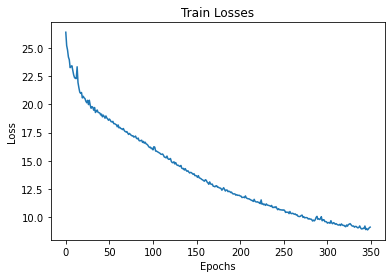

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.title("Train Losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [12]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [13]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

Sampling

In [14]:
S = X_test.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = decoder(z)

In [15]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

In [16]:
x_samples.mean(0)

tensor([ 0.1258, -0.2687,  0.0725, -0.0354, -0.0371,  0.0071, -0.0276,  0.1093,
        -0.0411,  0.1346,  0.1082,  0.0022, -0.0583], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [17]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [18]:
x_samples.std(0)

tensor([2.3441, 3.4316, 1.3684, 0.3796, 1.2686, 0.3736, 0.9307, 0.9759, 1.5892,
        1.1762, 0.9180, 1.8741, 0.9141], dtype=torch.float64,
       grad_fn=<StdBackward1>)

In [19]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

Text(0, 0.5, 'Mean of Generated Distribution')

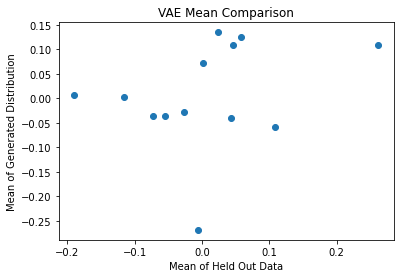

In [20]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

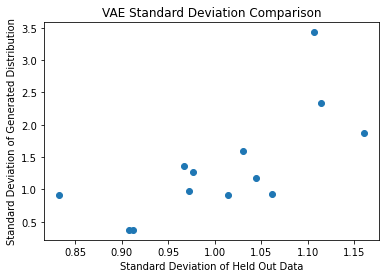

In [21]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

In [22]:
# figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
# for i in range(x_samples.shape[1]):
#     axs[i].scatter([x_test[:,i], x_samples[:,i]], color=['red','green'])
#     axs[i].legend(["data", "sample"])
# plt.show()

In [23]:
X_test.shape

torch.Size([152, 13])

<function matplotlib.pyplot.show(close=None, block=None)>

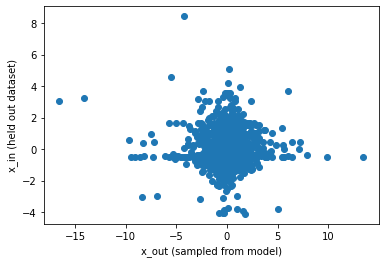

In [24]:
plt.scatter(x_samples.detach().numpy(), X_test)
plt.xlabel("x_out (sampled from model)")
plt.ylabel("x_in (held out dataset)")
plt.show

In [25]:
X_test.shape

torch.Size([152, 13])

In [26]:
x_samples.shape

torch.Size([152, 13])

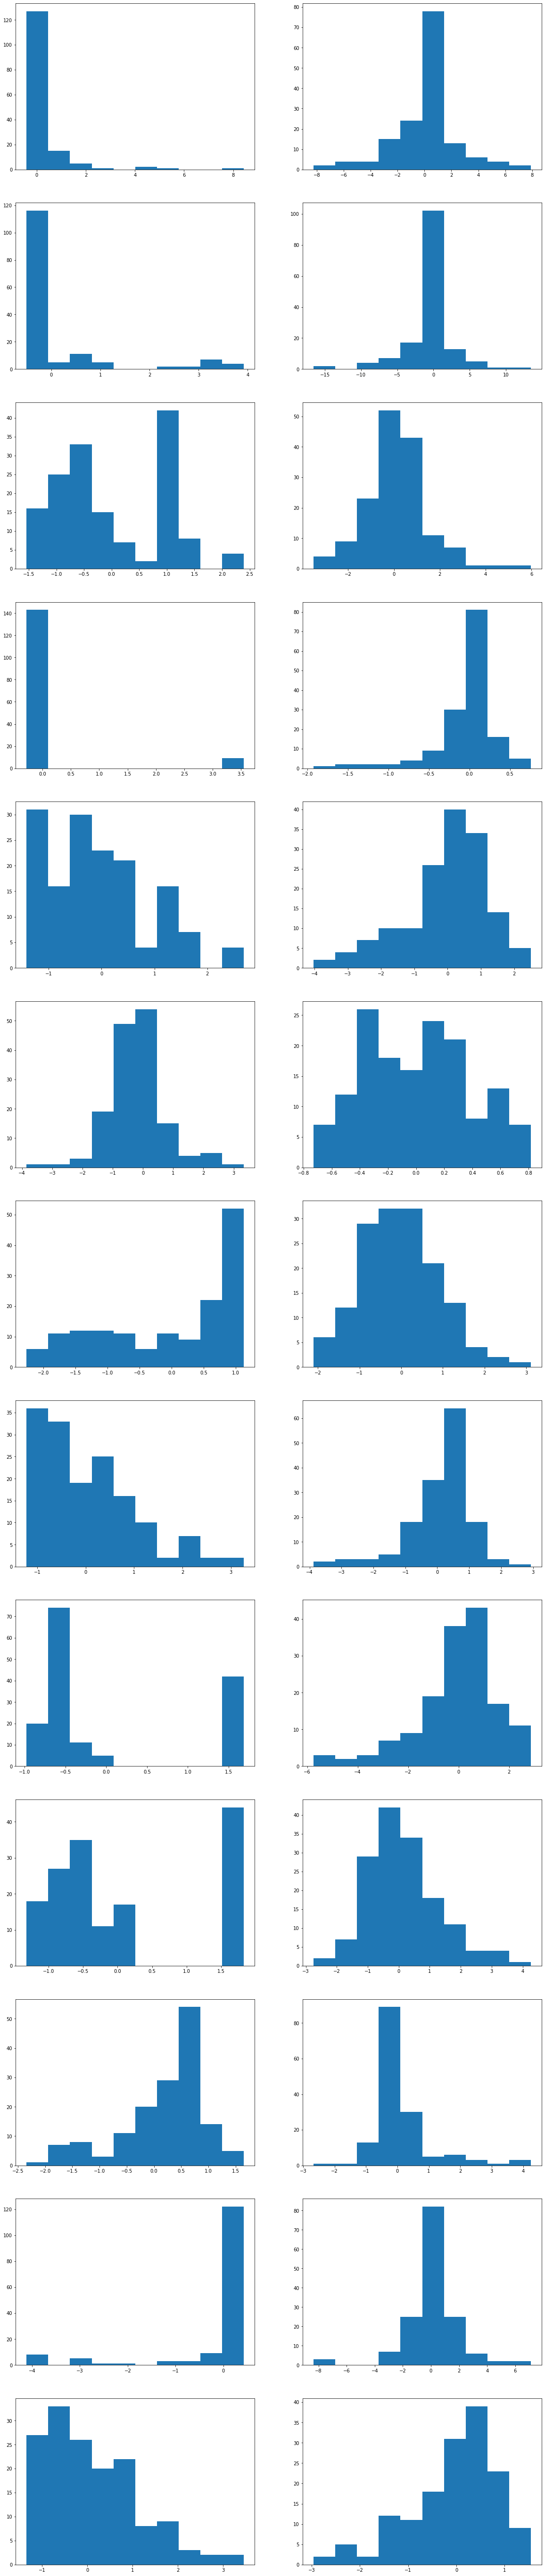

In [27]:
x_test = X_test.numpy()
x_samples = x_samples.detach().numpy()
figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
for i in range(x_samples.shape[1]):
    axs[i, 0].hist(x_test[:,i])
    axs[i, 1].hist(x_samples[:,i])
plt.show()

In [28]:
x_samples.mean(0)

array([ 0.12579549, -0.26869144,  0.0725167 , -0.0353695 , -0.03714   ,
        0.00711979, -0.02762192,  0.10932612, -0.04105966,  0.1345669 ,
        0.10818142,  0.0022088 , -0.05832492])

In [29]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [30]:
x_samples.std(0)

array([2.33634933, 3.42029229, 1.36392649, 0.37839251, 1.26437982,
       0.3723619 , 0.92758664, 0.97266538, 1.58397586, 1.17236759,
       0.91495235, 1.86788511, 0.91109942])

In [31]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

1. What are the 13 features 
2. What does plotting the histogram represent. 

In [32]:
np.corrcoef(X_test, rowvar=False)[0]

array([ 1.        , -0.1910687 ,  0.42486438, -0.08718963,  0.46821577,
       -0.23795259,  0.38613771, -0.40293044,  0.63190985,  0.58463217,
        0.27942462, -0.52906495,  0.55059428])

In [33]:
np.corrcoef(x_samples, rowvar=False)[0]

array([ 1.        , -0.01736488,  0.07956899, -0.00417537, -0.03785993,
       -0.04215773, -0.03864944, -0.04139365, -0.11763129,  0.13460249,
        0.04906961, -0.18312735,  0.03500765])

In [34]:
np.corrcoef(X_test, rowvar=False)[1]

array([-0.1910687 ,  1.        , -0.51290453, -0.06876205, -0.49604812,
        0.34901083, -0.54269001,  0.65072851, -0.29812013, -0.33169892,
       -0.45453415,  0.18209134, -0.45634992])

In [35]:
np.corrcoef(x_samples, rowvar=False)[1]

array([-0.01736488,  1.        , -0.10778168, -0.09925301, -0.19938738,
        0.22666984, -0.14345709,  0.19304603, -0.14596346, -0.15006908,
       -0.20294821,  0.07245695, -0.19608164])

In [36]:
np.corrcoef(X_test, rowvar=False)[2]

array([ 0.42486438, -0.51290453,  1.        ,  0.03220062,  0.76409769,
       -0.35575224,  0.66757595, -0.72731343,  0.63361793,  0.7646962 ,
        0.45750608, -0.41160893,  0.66605524])

In [37]:
np.corrcoef(x_samples, rowvar=False)[2]

array([ 0.07956899, -0.10778168,  1.        ,  0.40914198,  0.38769982,
       -0.50761487,  0.36352123, -0.45065647,  0.22086679,  0.27502469,
        0.24956527, -0.07867698,  0.41398123])

In [38]:
np.corrcoef(X_test, rowvar=False)[3]

array([-0.08718963, -0.06876205,  0.03220062,  1.        ,  0.06471079,
       -0.05183806,  0.09452797, -0.06774048, -0.14252854, -0.15269275,
       -0.21787821, -0.00468345,  0.07728061])

In [39]:
np.corrcoef(x_samples, rowvar=False)[3]

array([-0.00417537, -0.09925301,  0.40914198,  1.        ,  0.53098954,
       -0.41700693,  0.43703135, -0.33236705,  0.15960004,  0.12044971,
        0.10913525, -0.16353031,  0.36345732])